# Event-related Analysis

This example shows how to use Neurokit to extract epochs from data based on events localisation and its corresponding physiological signals. That way, you can compare *experimental conditions* with one another.

In [1]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images
plt.rcParams['font.size']= 14

## The Dataset

Use the `nk.data()` function to load the dataset located on Neurokit data folder. 

It contains 2.5 minutes of biosignals recorded at a frequency of 100Hz (2.5 x 60 x 100 = 15000 data points).

Biosignals : **ECG, RSP, EDA + Photosensor (event signal)**

In [3]:
# Get data
data = nk.data("bio_eventrelated_100hz")

This is the data from ***1*** **participant** to whom was presented 4 images (emotional stimuli, [IAPS-like emotional faces](https://en.wikipedia.org/wiki/International_Affective_Picture_System)), which we will refer to as **events**. 

Importantly, the images were marked by a small black rectangle on the screen, which led to the photosensor signal to go down (and then up again after the image). This is what will allow us to retrieve the location of these events.

They were 2 types (the **condition**) of images that were shown to the participant: **"Negative"** vs. **"Neutral"** in terms of emotion. Each picture was presented for 3 seconds. The following list is the condition order.

In [4]:
condition_list = ["Negative", "Neutral", "Neutral", "Negative"]

## Find Events

These events can be localized and extracted using [events_find()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.events_find). 

*Note that you should also specify whether to select events that are higher or below the threshold using the `threshold_keep` argument.*

In [5]:
# Find events
events = nk.events_find(data["Photosensor"], threshold_keep='below', event_conditions=condition_list)
events

{'onset': array([ 1024,  4957,  9224, 12984]),
 'duration': array([300, 300, 300, 300]),
 'label': array(['1', '2', '3', '4'], dtype='<U11'),
 'condition': ['Negative', 'Neutral', 'Neutral', 'Negative']}

As we can see, `events_find()` returns a dict containing onsets and durations for each corresponding event, based on the label for event identifiers and each event condition. Each event here lasts for 300 data points (equivalent to 3 seconds sampled at 100Hz).

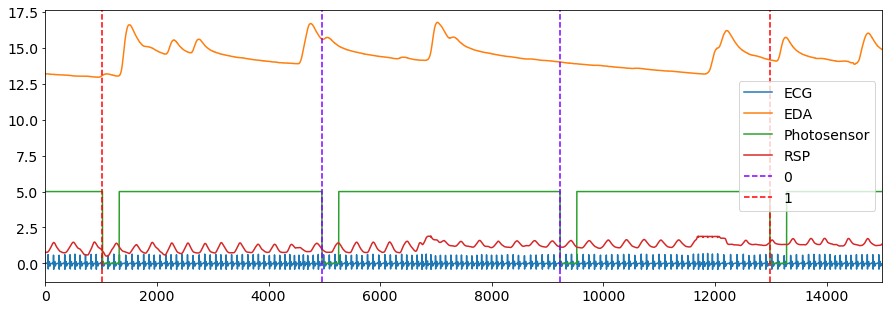

In [6]:
# Plot the location of event with the signals
plot = nk.events_plot(events, data)

The output of [events_plot()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.events_plot) shows the corresponding events in the signal, with the blue dashed line representing a Negative event and red dashed line representing a Neutral event.

## Process the Signals

Now that we have the events location, we can go ahead and process the data.

Biosignals processing can be done quite easily using NeuroKit with the [bio_process()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.bio_process) function. Simply provide the appropriate biosignal channels and additional channels that you want to keep (for example, the photosensor), and `bio_process()` will take care of the rest. It will return a dataframe containing processed signals and a dictionary containing useful information.

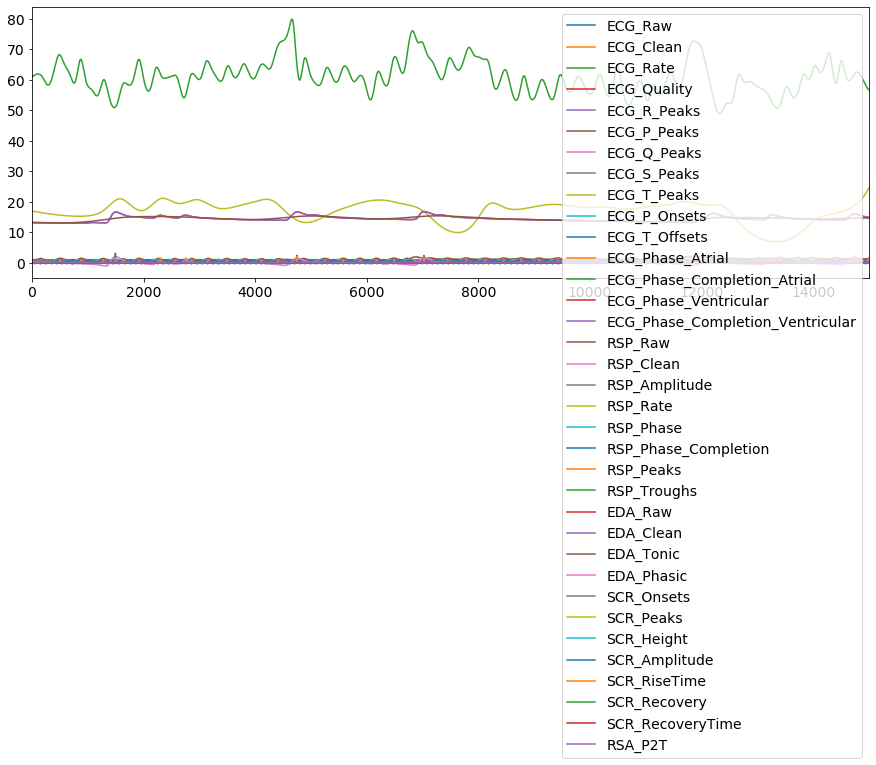

In [7]:
# Process the signal
df, info = nk.bio_process(ecg=data["ECG"], rsp=data["RSP"], eda=data["EDA"], sampling_rate=100)

# Visualize
df.plot()
                                            # theres is a ton of features now, but not in epochs

## Create Epochs

We now have to transform this dataframe into **epochs**, i.e. segments (chunks) of data around the **events** using [epochs_create()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.epochs_create). 

    1. We want it to start *1 second before the event onset*

    2. and end *6 seconds* afterwards
These are passed into the `epochs_start` and `epochs_end` arguments, respectively. 

Our epochs will then cover the region from **-1 s** to **+6 s** (i.e., 700 data points since the signal is sampled at 100Hz).

In [8]:
# Build and plot epochs
epochs = nk.epochs_create(df, events, sampling_rate=100, epochs_start=-1, epochs_end=6)

Let's plot some of the signals of the first epoch (and transform them to the same scale for visualization purposes). 

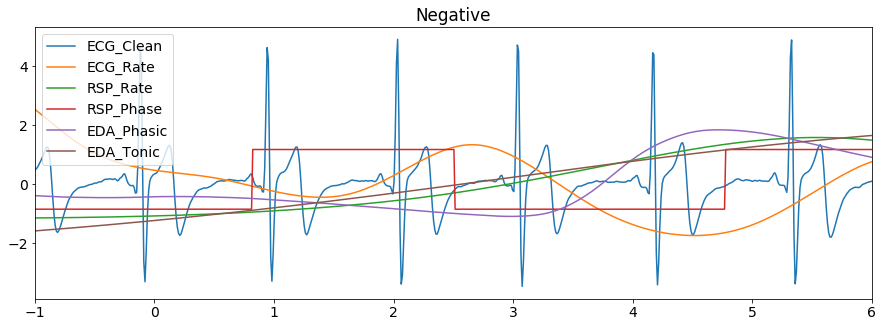

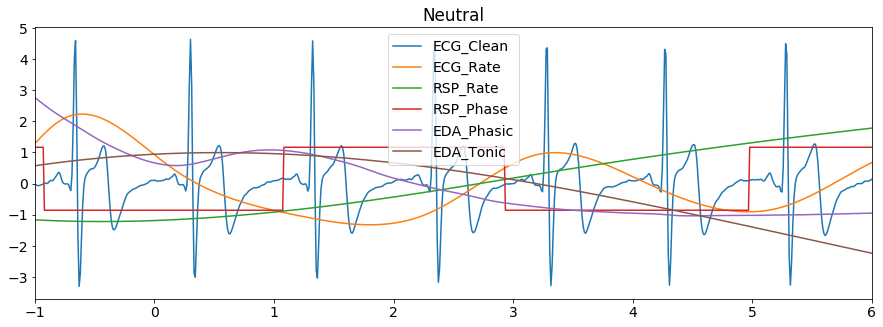

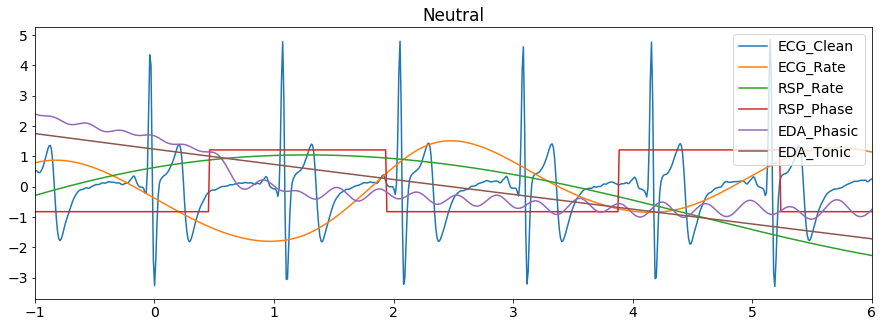

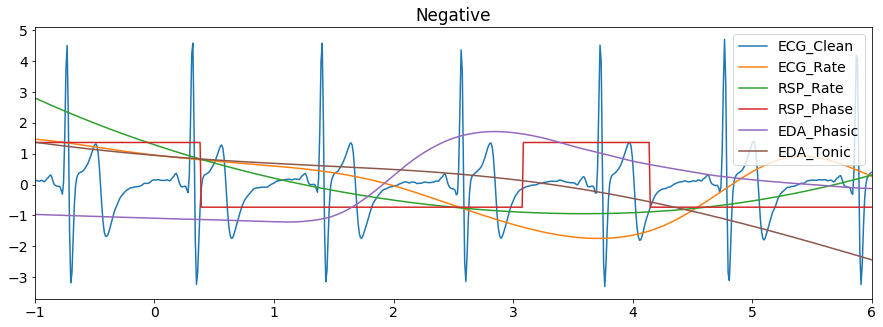

In [9]:
for i, epoch in enumerate (epochs):
    epoch = epochs[epoch]  # iterate epochs",
    
    epoch = epoch[['ECG_Clean', 'ECG_Rate', 'RSP_Rate',
                   'RSP_Phase', 'EDA_Phasic', 'EDA_Tonic']]  # Select relevant columns",
    
    title = events['condition'][i] # get title from condition list",
    
    nk.standardize(epoch).plot(title=title, legend=True)  # Plot scaled signals"

## Extract Event Related Features

With these segments, we are able to compare how the physiological signals vary across the different events. We do this by:
1. **Iterating through our object epochs** 

2. **Storing the mean value of $X$ feature of each condition in a new dictionary**

3. **Saving the results in a readable format**


We can call them *epochs-dictionary*, the *mean-dictionary* and our *results-dataframe*.



In [10]:
df = {}  # Initialize an empty dict, 
         
for epoch_index in epochs:
    df[epoch_index] = {}  # then Initialize an empty dict inside of it with the iterative 
                            
    # Save a temp var with dictionary called <epoch_index> in epochs-dictionary
    epoch = epochs[epoch_index]

    # We want its features:

    # Feature 1 ECG
    ecg_baseline = epoch["ECG_Rate"].loc[-100:0].mean()  # Baseline
    ecg_mean = epoch["ECG_Rate"].loc[0:400].mean()  # Mean heart rate in the 0-4 seconds
    # Store ECG in df
    df[epoch_index]["ECG_Rate"] = ecg_mean - ecg_baseline  # Correct for baseline

    
    # Feature 2 EDA - SCR
    scr_max = epoch["SCR_Amplitude"].loc[0:600].max()  # Maximum SCR peak
    # If no SCR, consider the magnitude, i.e.  that the value is 0
    if np.isnan(scr_max):
        scr_max = 0  
    # Store SCR in df
    df[epoch_index]["SCR_Magnitude"] = scr_max

    # Feature 3 RSP
    rsp_baseline = epoch["RSP_Rate"].loc[-100:0].mean()  # Baseline
    rsp_rate = epoch["RSP_Rate"].loc[0:600].mean()
    # Store RSP in df
    df[epoch_index]["RSP_Rate"] = rsp_rate - rsp_baseline  # Correct for baseline


df = pd.DataFrame.from_dict(df, orient="index")  # Convert to a dataframe
df["Condition"] = condition_list  # Add the conditions
df  # Print DataFrame

,ECG_Rate,SCR_Magnitude,RSP_Rate,Condition
1,-4.286137,3.114808,2.729480,Negative
2,-5.387987,0.000000,2.094437,Neutral
3,-1.400696,0.000000,-0.062720,Neutral
4,-3.804883,1.675922,-1.674218,Negative


## Plot Event Related Features


You can now plot and compare how these features differ according to the event of interest.

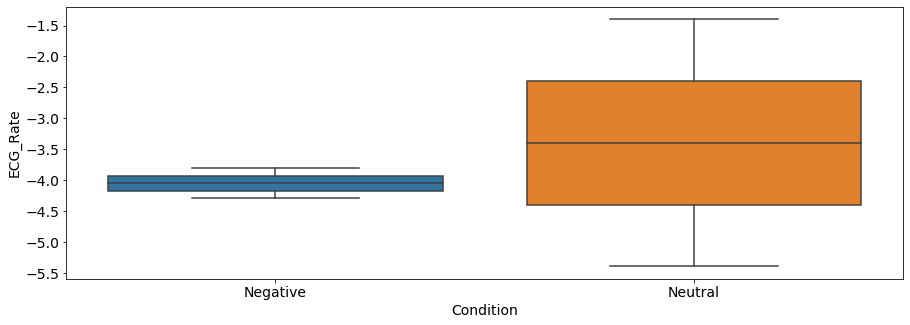

In [11]:
sns.boxplot(x="Condition", y="ECG_Rate", data=df)

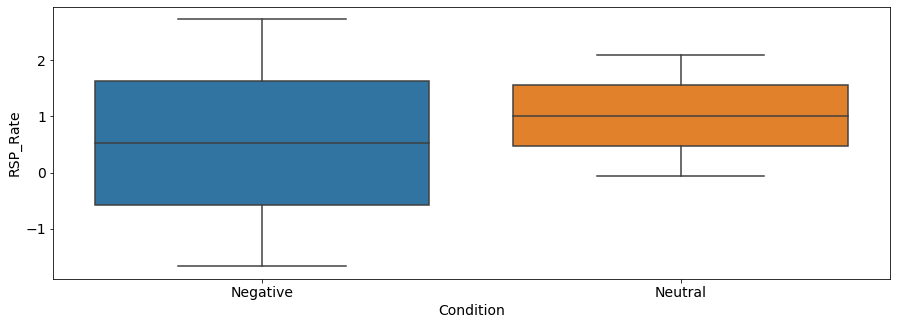

In [12]:
sns.boxplot(x="Condition", y="RSP_Rate", data=df)

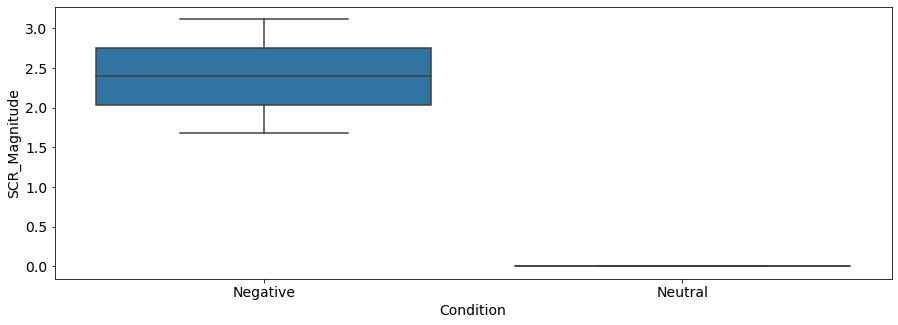

In [13]:
sns.boxplot(x="Condition", y="SCR_Magnitude", data=df)

*Then interpret* : As we can see, there seems to be a difference between the negative and the neutral pictures. Negative stimuli, as compared to neutral stimuli, were related to a stronger cardiac deceleration (i.e., higher heart rate variability), an accelerated breathing rate, and higher SCR magnitude. 

## Important remarks:
You can't break anything if you're on Binder, so have fun. Keep in mind that *this is for illustration purposes only*.

Data size limits on Github force us to downsample and have only one participant (sample rate would have to be >250 Hz, and you can't do stats with 4 observations in 1 subjects).

We invite you to read on reporting guidelines for biosignal measures. For ECG-PPG/HRV : [Quintana, Alvarez & Heathers, 2016 - GRAPH](https://www.ncbi.nlm.nih.gov/pubmed/27163204)